# Analysis

This code takes the csv output from previous codes and the segmentations and prints the intensity profile on average over time of a single (random) image. It also compares all the different images in a boxplot. 



In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import random
import napari
import tifffile
#import napari_bleach_correct
from tqdm import tqdm
from skimage.measure import find_contours, perimeter
import python_test


In [2]:
viewer = napari.Viewer()

In [4]:
HOME = '/home/sim/OneDrive/'
csv_path = HOME + 'Data/by_projects/gcamp/csvs_new_trained_from_scratch/'
masks_path = HOME + 'Data/by_projects/gcamp/masks_new_trained_scratch/'
tif_path = HOME + 'Data/by_projects/gcamp/tif/'
csv_random = os.listdir(csv_path)

In [7]:
# individual cells
def load_data_napari(xpath, ypath):
    X = tifffile.imread(xpath)
    Y = tifffile.imread(ypath)
    X = X[:Y.shape[0],:,:]
    viewer.add_image(X)
    viewer.add_labels(Y, name='masks')
    return X, Y

def histogram_equalisation(X):
    contrast_limits = napari.layers.utils.layer_utils.calc_data_range(X)
    return napari_bleach_correct.modules.histogram_correct(X, contrast_limits)

def expo_equalisation(X):
    contrast_limits = napari.layers.utils.layer_utils.calc_data_range(X)
    return napari_bleach_correct.modules.exponential_correct(X, contrast_limits)

def expo_decay(t, I0, k, c):
    return I0 * np.exp(-k * t) + c

def intensity_over_time(X):
    intensity = np.mean(X, axis=(1,2))
    plt.plot([i for i in range(len(intensity))], intensity, '.')
    plt.show()

In [10]:
random_id = random.randint(0, len(csv_random))
f = csv_random[random_id]
print(f)
#X, Y = load_data_napari(tif_path + f[:-4] + '.tif', masks_path + f[:-4] + '.tif')
#intensity_over_time(X)

Oua 200 nM 23 03 29_41_6.csv


### How to select the 'good' cells from the image?

There could be different indicators, such as:
- size
- amount of times it appears over time (tracking related)
- 

In [14]:
def plot_label_size_over_time(Y):
    label_sizes = {}
    
    for l in tqdm(np.unique(Y)):
        sizes = []
        for t in range(Y.shape[0]):
            sizes.append(np.sum(Y[t,:,:]==l))
        label_sizes[l] = sizes
    return label_sizes
    # boxplot


label_sizes = plot_label_size_over_time(Y)

100%|██████████| 481/481 [02:57<00:00,  2.71it/s]


In [85]:
def calculate_circumference(y):
    circumferences = []
    for t in range(y.shape[0]):
        circumference = perimeter(y[t,:,:])
        circumferences.append(circumference)
    return circumferences        

def filter_label_ids(label_sizes, lim_timepoints = 0.8, lim_size = 700, lim_circumference = 700): # 2500, 700
    filter_list = []
    all_labels = {}
    # get the number of total timepoints
    number_of_timepoints = len(label_sizes[0])
    for label_id in tqdm(label_sizes.keys()):
        # find the number of times the label is not present
        timepoints = [i for i in range(len(label_sizes[label_id])) if label_sizes[label_id][i] > 0]
        # calculate the std of the label size
        size_std = np.std(label_sizes[label_id])
        ## calculate the std of the circumference
        #circumference_std = np.std(calculate_circumference(Y == label_id))
        #print(circumference_std)
        ## save all three to dict
        all_labels[label_id] = [len(timepoints), size_std]#, circumference_std]
        
        # filter the label_ids
        if len(timepoints) > number_of_timepoints * lim_timepoints and size_std < lim_size:# and circumference_std < lim_circumference:
                filter_list.append(label_id)

    return filter_list, all_labels

filter_list, all_labels = filter_label_ids(label_sizes,
                                           lim_timepoints = 0.9, 
                                           lim_size = 500)

# overlay only specific labels of Y to napari from given filter list
def overlay_label(Y, label_ids):
    Y_overlay = np.zeros(Y.shape)
    for l in tqdm(label_ids):
        Y_overlay[Y==l] = l
    Y_overlay = Y_overlay.astype(np.uint16)
    viewer.add_labels(Y_overlay, name='overlay')
    return Y_overlay

Y_overlay = overlay_label(Y, filter_list)

100%|██████████| 78/78 [00:27<00:00,  2.82it/s]


label_id: 2, number of times label is present over time: 654, fluctuation: 244.540991849976


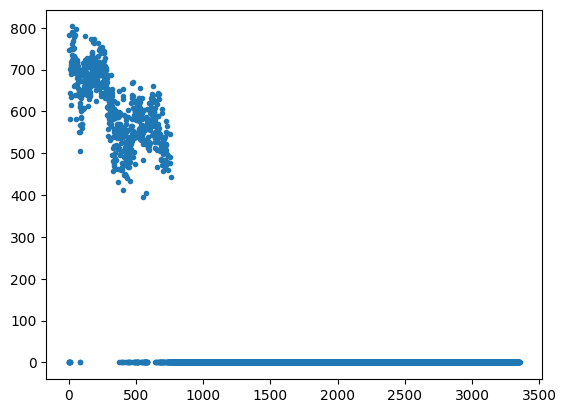

In [89]:
# present label id, number of times label is present over time and fluctuation is printed
label_id = 2
print(f"label_id: {label_id}, number of times label is present over time: {all_labels[label_id][0]}, fluctuation: {all_labels[label_id][1]}")
# plot size over time
plt.plot([i for i in range(len(label_sizes[label_id]))], label_sizes[label_id], '.')
plt.show()

In [6]:
def corr_selected(csv_path, cell_list = None):
    '''
    csv_path: path to csv file
    cell_list: list of cell ids to select

    Code to select correlation values from csv file
    possible to select specific cells or all cells
    '''    
    csv = pd.read_csv(csv_path)
    corr_all = csv.iloc[3]
    
    if cell_list != None:
        corr = corr_all.to_dict()
        corr = [corr[str(i)] for i in cell_list]  
        corr = [float(i) for i in corr if not math.isnan(float(i))]
        return corr
      
    else:
        corr  = corr_all.tolist()[1:]
        corr = [float(i) for i in corr if not math.isnan(float(i))]
        return corr

corr_select = corr_selected(csv_path + f)#, cell_list=cell_list)

## Boxplot all conditions to compare

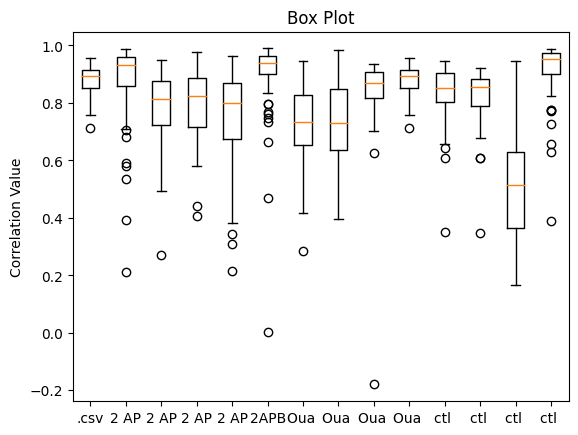

In [12]:
data = {}
#csv_path = '/home/sim/OneDrive/Data/by_projects/gcamp/csvs_new_trained_from_scratch/'
for f in os.listdir(csv_path):
    csv = pd.read_csv(csv_path + f)
    corr = csv.iloc[3].tolist()[1:]
    corr = [float(i) for i in corr if not math.isnan(float(i))]
    data[f] = corr


# boxplot
data = dict(sorted(data.items()))
plt.boxplot(data.values(), labels=[i[:4] for i in data.keys()])
plt.title('Box Plot')
plt.ylabel('Correlation Value')
plt.show()

In [15]:
print(csv)

                                          Unnamed: 0  \
0                                        Intensities   
1                                     Center of mass   
2                                      Border values   
3                 Weighted max NCC for border values   
4  Weighted time difference at max NCC for border...   
5                           Most prominent frequency   

                                                   2  \
0  [18545.95365602 21038.48793284 19733.78331638 ...   
1              [13.70854788877446, 182.697219361483]   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3                                 0.8561599047102271   
4                                  9.249999999999998   
5                              0.0010460251046025104   

                                                   5  \
0  [26546.23475445 26480.52953586 25537.85714286 ...   
1            [28.741500269832702, 377.1851052347545]   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
print(csv.iloc[0].tolist())

['Intensities', '[18545.95365602 21038.48793284 19733.78331638 ... 11072.72598162\n 11122.16374269 11133.34502924]', '[26546.23475445 26480.52953586 25537.85714286 ... 12940.94093178\n 12786.57213115 12816.02852486]', '[12033.87242318 12062.16864511 11738.73030057 ...  9144.4648847\n  9015.34588859  8893.08544304]', '[10291.04817789 10244.21142857  9865.81277955 ... 15342.51885925\n 15220.58592322 15222.76645042]', '[12646.28533333 12002.47422096 11610.98090388 ... 10409.35824916\n 10296.89361702 10282.83814641]', '[17443.69843431 20184.40214477 15117.39446367 ... 11545.81863665\n 11514.84479495 11605.84918648]', '[21019.21389029 20858.57941613 20682.47055913 ... 16536.68320831\n 16482.56732394 16384.85395764]', '[13108.72168285 13104.20991848 11462.69120801 ... 15831.54128993\n 15896.78355502 15928.0175219 ]', '[9293.22285354 9271.19246862 9424.21266667 ... 9924.86030429 9972.4868603\n 9904.97786999]', '[12470.05424528 12100.76671975 12043.62168309 ... 18095.92516411\n 18008.62840809 